In [1]:
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt

from ipynb.fs.full.Functions import generate_asset_payoff, generate_trader_valuation, generate_dealer_action, generate_q_matrix

# Variable Setting

This is where we can set the variables of our economic environment. We can play around with these variables.

In [2]:
# Asset parameters
payoff_high = 4
prob_high = 0.5
payoff_low = 0
prob_low = 0.5
expected_payoff = payoff_high*prob_high + payoff_low*prob_low

# Dealer parameter
no_of_dealer = 2
lowest_ask_price = 1
highest_ask_price = 15
possible_ask_price = np.arange(lowest_ask_price, highest_ask_price+1, 1)

# Trader parameters
private_valuation_mean = 0
private_valuation_sd = 5

# Learning parameters
alpha = 0.01
beta = 0.0008
lower_q = 3
upper_q = 6

# Number of Experiments and Episode
K = 500
T = 200000

# Duopoly Situation

Here, we run the simulation in the duopoly market maker situation, where there are two dealer in the market.

In [3]:
dealer_1_greedy_price_df = pd.DataFrame(np.arange(1,T+1,1), columns = ['episodes'])
dealer_2_greedy_price_df = pd.DataFrame(np.arange(1,T+1,1), columns = ['episodes'])

# k iterates for each experiment, we will use k as the random seed for each experiment as well
for k in np.arange(1,K+1,1):

    # Track Process
    if k%100 == 0: print(str(k/K*100) + "%")

    # This array saves the historical greedy prices for each experiment
    dealer_1_historical_greedy_price = np.array([])
    dealer_2_historical_greedy_price = np.array([])

    # Initate experiment with initial variables (Asset Payoff, Trader Valuation, Dealer Action, Q-Matrix)
    asset_payoff = generate_asset_payoff(prob_low, prob_high, payoff_low, payoff_high,T,k)
    trader_valuation = generate_trader_valuation(generate_asset_payoff(prob_low, prob_high, payoff_low, payoff_high,T,k), private_valuation_mean,private_valuation_sd,k)
    # For dealer_2, we added K to its initial seed so that two dealer's action in any experiment will not be the same, dealer_1's action will loop from 1 to K and dealer_2's action will loop from K+1 to 2K
    dealer_1_action = generate_dealer_action(beta,T,k)
    dealer_2_action = generate_dealer_action(beta,T,K+k)
    Q_matrix = generate_q_matrix(lower_q, upper_q, len(possible_ask_price), no_of_dealer,k)

    # Set random seed for ask_price randomisation during "explore", we iterate this over every experiment to make sure different experiments are selecting different "explore" ask prices
    random.seed(k)

    # Loop over each episode
    for t in np.arange(0,T,1):
        
        # Dealer 1 choose to explore or exploit
        if dealer_1_action[t] == "explore":
            # If explore, ask_price is random integer from 1 to 15, since we have set seed=k above, this makes sure that ask_prices are taken at random differently in each experiment
            dealer_1_ask_price = random.choice(possible_ask_price)

        if dealer_1_action[t] == "exploit":
            # If exploit, ask_price is the action with the highest expected payoff from Q_matrix
            dealer_1_ask_price = np.argmax(Q_matrix.iloc[:,0])+1

            # Use an array to save historical ask prices
            dealer_1_historical_greedy_price = np.append(dealer_1_historical_greedy_price, dealer_1_ask_price)

            # Stop if greedy price for both dealers didn't change for 10000 episodes
            if len(dealer_1_historical_greedy_price) > 10000 and np.std(dealer_1_historical_greedy_price[-10000:]) == 0 and \
            len(dealer_2_historical_greedy_price) > 10000 and np.std(dealer_2_historical_greedy_price[-10000:]) == 0:
                break


        # Dealer 2 choose to explore or exploit
        if dealer_2_action[t] == "explore":
            # If explore, ask_price is random integer from 1 to 15, since we have set seed=k above, this makes sure that ask_prices are taken at random differently in each experiment
            dealer_2_ask_price = random.choice(possible_ask_price)

        if dealer_2_action[t] == "exploit":
            # If exploit, ask_price is the action with the highest expected payoff from Q_matrix
            dealer_2_ask_price = np.argmax(Q_matrix.iloc[:,1])+1

            # Use an array to save historical ask prices
            dealer_2_historical_greedy_price = np.append(dealer_2_historical_greedy_price, dealer_2_ask_price)

            # Stop if greedy price for both dealers didn't change for 10000 episodes
            if len(dealer_1_historical_greedy_price) > 10000 and np.std(dealer_1_historical_greedy_price[-10000:]) == 0 and \
            len(dealer_2_historical_greedy_price) > 10000 and np.std(dealer_2_historical_greedy_price[-10000:]) == 0:
                break


        # Minimum dealer price for this episode
        all_ask_prices = [dealer_1_ask_price, dealer_2_ask_price]
        lower_ask_price = min(all_ask_prices)
        higher_ask_price = max(all_ask_prices)

        # Create a binary variable that is 1 when both dealer offers the same ask price
        if np.std(all_ask_prices) == 0: 
            whether_same_ask_prices = 1
        else:
            whether_same_ask_prices = 0


        # Informed trader now chooses whether to trade in this episode according to the lowest_ask_price and which dealer to trade with
        # Case 1) Trader chooses to trade with both dealers
        if trader_valuation[t] >= lower_ask_price and whether_same_ask_prices == 1:
            Q_matrix.iloc[dealer_1_ask_price-1,0] = alpha*(dealer_1_ask_price-asset_payoff[t])/2 + (1-alpha)*Q_matrix.iloc[dealer_1_ask_price-1,0]
            Q_matrix.iloc[dealer_2_ask_price-1,1] = alpha*(dealer_2_ask_price-asset_payoff[t])/2 + (1-alpha)*Q_matrix.iloc[dealer_2_ask_price-1,1]

        # Case 2) Trader chooses to trade with one dealer with the lower ask price
        if trader_valuation[t] >= lower_ask_price and whether_same_ask_prices == 0:
            lower_price_dealer = np.argmin(all_ask_prices)
            higher_price_dealer = np.argmax(all_ask_prices)
            Q_matrix.iloc[lower_ask_price-1,lower_price_dealer] = alpha*(lower_ask_price-asset_payoff[t]) + (1-alpha)*Q_matrix.iloc[lower_ask_price-1,lower_price_dealer]
            Q_matrix.iloc[higher_ask_price-1,higher_price_dealer] = (1-alpha)*Q_matrix.iloc[higher_ask_price-1,higher_price_dealer]

        # Case 3) Trader chooses not to trade
        if trader_valuation[t] < lower_ask_price:
            Q_matrix.iloc[dealer_1_ask_price-1,0] = (1-alpha)*Q_matrix.iloc[dealer_1_ask_price-1,0]
            Q_matrix.iloc[dealer_2_ask_price-1,1] = (1-alpha)*Q_matrix.iloc[dealer_2_ask_price-1,1]
        
    # Save the historical greedy price for this experiment in the dataframe
    dealer_1_greedy_price_df = pd.concat([dealer_1_greedy_price_df, pd.DataFrame(dealer_1_historical_greedy_price, columns = ['experiment' + str(k)])], axis = 1)
    dealer_2_greedy_price_df = pd.concat([dealer_2_greedy_price_df, pd.DataFrame(dealer_2_historical_greedy_price, columns = ['experiment' + str(k)])], axis = 1)

dealer_1_greedy_price_df.set_index("episodes", inplace = True)
dealer_2_greedy_price_df.set_index("episodes", inplace = True)

20.0%
40.0%
60.0%
80.0%
100.0%


In [10]:
#dealer_1_greedy_price_df.to_csv("duopoly_dealer_1_price.csv")
#dealer_2_greedy_price_df.to_csv("duopoly_dealer_2_price.csv")
dealer_1_greedy_price_df = pd.read_csv("duopoly_dealer_1_price.csv")
dealer_2_greedy_price_df = pd.read_csv("duopoly_dealer_2_price.csv")
dealer_1_greedy_price_df.set_index("episodes", inplace = True)
dealer_2_greedy_price_df.set_index("episodes", inplace = True)

# Results

Similarly, we will be analyzing the results here with graphs.

We first look at how the average greedy price changes over episodes for the two market marker. This gives us the idea of how the two market maker learns from each other and the environment.

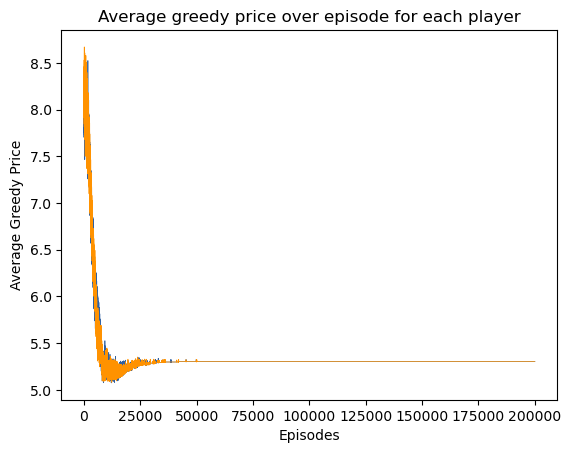

In [18]:
plt.title("Average greedy price over episode for each player")
plt.plot(dealer_1_greedy_price_df.ffill().mean(axis = 1), color = "#2e5fa1", linewidth = 0.5)
plt.plot(dealer_2_greedy_price_df.ffill().mean(axis = 1), color = "#ff9200", linewidth = 0.5)
plt.xlabel("Episodes")
plt.ylabel("Average Greedy Price")
plt.savefig("Duopoly average greedy price over time for each player.png")
plt.show()

We are also interested in the final greedy price market makers arrives in.

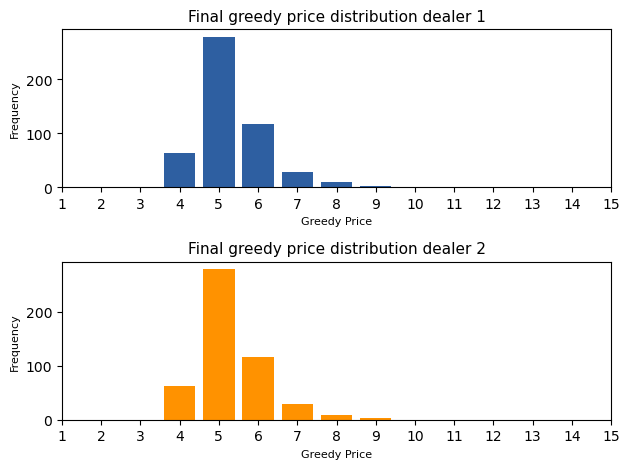

In [58]:
dealer_1_greedy_prices, dealer_1_greedy_prices_freq = np.unique(dealer_1_greedy_price_df.ffill(axis = 0).iloc[-1,:], return_counts = True)
dealer_2_greedy_prices, dealer_2_greedy_prices_freq = np.unique(dealer_2_greedy_price_df.ffill(axis = 0).iloc[-1,:], return_counts = True)

fig, axs = plt.subplots(nrows = 2, ncols = 1)
axs[0].bar(dealer_1_greedy_prices, dealer_1_greedy_prices_freq, color = "#2e5fa1")
axs[0].set_title("Final greedy price distribution dealer 1", fontsize = 11)
axs[0].set_xlabel("Greedy Price", fontsize = 8)
axs[0].set_ylabel("Frequency", fontsize = 8)
axs[0].set_xticks(np.arange(1,16,1))

axs[1].bar(dealer_2_greedy_prices, dealer_2_greedy_prices_freq, color = "#ff9200")
axs[1].set_title("Final greedy price distribution dealer 2", fontsize = 11)
axs[1].set_xlabel("Greedy Price", fontsize = 8)
axs[1].set_ylabel("Frequency", fontsize = 8)
axs[1].set_xticks(np.arange(1,16,1))

fig.tight_layout()

plt.savefig("Duopoly final greedy price distribution for each player.png")
plt.show()